# Detecting bot accounts on Twitter.
The training and evaluation scripts can be inspected on https://www.kaggle.com/code/worker444/twibot22-hgt/notebook. They are also provided in twibot22-hgt_sample_evaluation.ipynb and twibot22-hgt_sample_training.ipynb.<br>
All experimental data can be inspected in the repository https://github.com/AmosDinh/Bot-or-User_Twitter-Classification.

## Motivation

In today's society, Social Networks are a primary source of information. Users utilize websites such as Twitter and Facebook to inform them selves about the latest events, discuss politics or social issues. It has also become a news outlet for traditional newspapers such as the New York Times or the Wall Street Journal. Politicians use Social Networks to communicate with the public. 

Independent parties use bots or large networks of bots which operate on these networks to fullfil their goals. Not all bots are malicious, such as bots which provide weather forecasts[1]. 

Three types of bot threats can be identified [1]. These bots often impersonate a real identity and therefore are difficult to distinguish from real users:
- Fraud: These types of bots deceive social media users to obtain money or private information.
- Promotion of harmful or censored information: Bots are utilized to spread propaganda or misinformation. These include:
    1. Thread to integrity: exacerbate conflict or violate the integrity of a community.
    2. Thread to availability: Drown alternative viewpoints with spam messages.

- Rating manipulation: Certain content is elevated through fake feedback including reviews, likes or followers.

In 2018, Twitter disclosed that 70 million fake accounts were present on the platform [1b]. The proportion of bots on Twitter is estimated between 9%-15%[1c].

How well humans can detect this large percentage of bots on Twitter is examined by a study of Ryan, et al. [1d] on 113 test participants, each evaluation 50 Twitter profiles on whether they belong to bots. Among the test subjects, those who report high confidence in their bot-detection ability perform worse. Further, test subjects are more likely to classify humans as bots and bots as humans, when the corresponding profile opposes their own viewpoint (political).  In a balanced dataset, the test subjects more often predicted "human". These results show, how non-expert end users are susceptible to the three types of bot threats. The scepticism of users towards opposing viewpoints further amplifies the creation of social bubbles.  


With the increasing effectiveness as well as ease of access to generative AI, such as text and image generation models more sophisticated impersonations and generation of fake media can be achieved, difficult or impossible to distinguish from real content. Malicious-bot operators have gained access to multi-billion dollar means which camouflage their bots' behavior. The generative models, trained with human feedback , effectively to be indistinguishable from real content, diminish the out-of-distribution shift which was previously easily detectable. 

Thus the focus of this notebook shifts from classifying based on text or images towards the behavioral and interaction patterns in social networks as well as user metadata to distinguish real from fake users. <br> These patterns are more difficult to camouflage, and thus are a promising direction of research.



[1] https://www.researchgate.net/profile/Maxim-Kolomeets/publication/358490063_Algorithms_and_techniques_for_bot_detection_in_social_networks/links/62afd5c5938bee3e3f438138/Algorithms-and-techniques-for-bot-detection-in-social-networks.pdf <br>
[1b] https://www.washingtonpost.com/technology/2018/07/06/twitter-is-sweeping-out-fake-accounts-like-never-before-putting-user-growth-risk<br>
[1c] https://arxiv.org/abs/1703.03107<br>
[1d] https://journals.sagepub.com/doi/full/10.1177/00187208211072642

## Dataset
Courtesy of Shangbin Feng this notebook uses the TwiBot-22 dataset[2] to analyze a social network graph of Twitter.
The authors try to ensure a distribution diversity (follower counts, user types) as well as value diversity (less similar neighbors are included) in the dataset. 

Human experts classify 1000 random users. Different classifiers are trained to distinguish the bots from the real users and their results are incorporated using the data augmentation technique Snorkel[3] to annotate the remaining users collected.

The dataset contains one million users as well as 88 million tweets. In total, the graph contains 92.9 million entities and 170 million relations amounting to a 6 GB file.



The graph comprises following node and edge types [2]:<br><br>
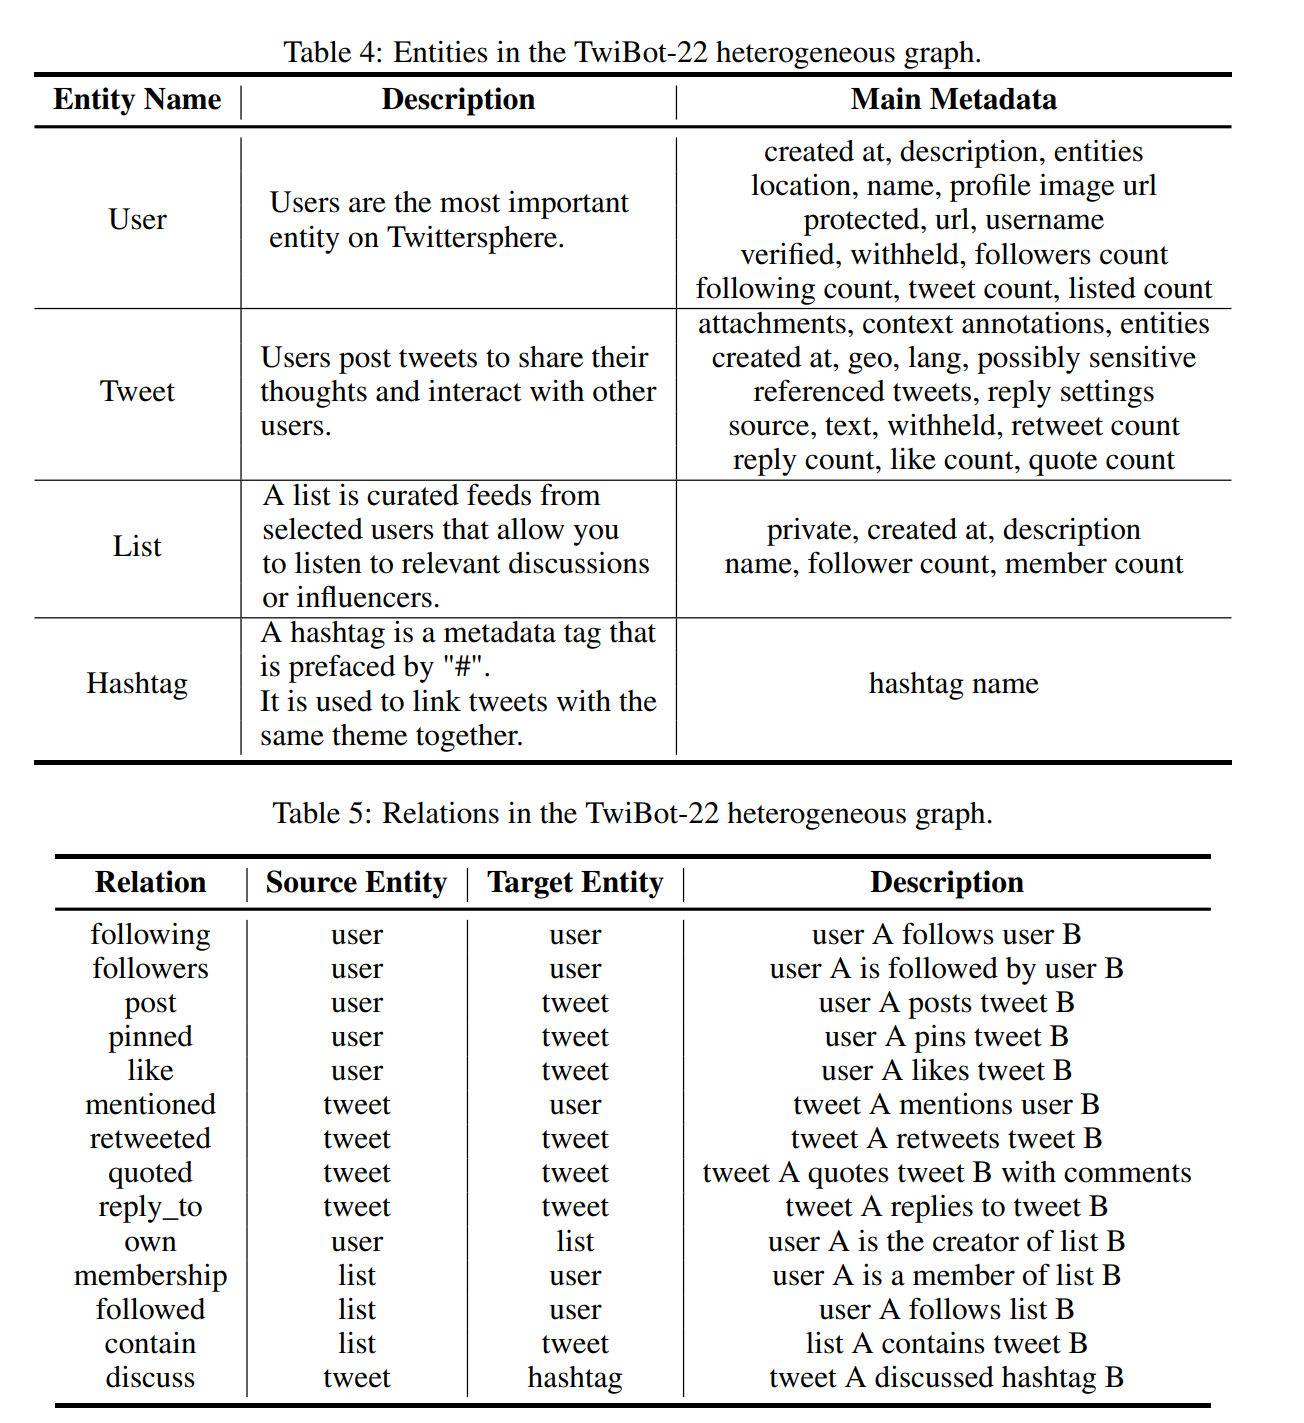

Besides the network information, TwiBot-22 also contains over 100 GB tweet information, which is not utilized in this notebook, due to computing constraints.

[2] https://arxiv.org/abs/2206.04564 <br>
[3] https://dawn.cs.stanford.edu/pubs/ratner-vldb2018.pdf

In [3]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
import torch 
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

/Users/amos/miniconda3/envs/gnntwitteranalysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
edges = pd.read_csv('data/edge.csv')
label = pd.read_csv('data/label.csv')

In [3]:
users = pd.read_json('data/user.json', lines=True)

In [4]:
# extract user data for training from jsons:

# One user: 
# {'created_at': '2014-07-02 17:56:46+00:00',
#  'description': 'creative _',
#  'entities': None,
#  'id': 'u2664730894',
#  'location': '🎈',
#  'name': 'olawale 💨',
#  'pinned_tweet_id': None,
#  'profile_image_url': 'https://pbs.twimg.com/profile_images/1478376381717401605/k4aboywe_normal.png',
#  'protected': False,
#  'public_metrics': {'followers_count': 123,
#   'following_count': 1090,
#   'tweet_count': 1823,
#   'listed_count': 0},
#  'url': '',
#  'username': 'wale_io',
#  'verified': False,
#  'withheld': None}


user_data = []
user_id = []
for row in tqdm(users.values.reshape(-1)):
    user_id.append(row['id'])
    user_data.append([row['public_metrics']['following_count'], row['public_metrics']['tweet_count'], row['public_metrics']['listed_count'], 0 if row['verified'] else 1, 0 if row['protected'] else 1])
    
user_data = np.array(user_data)

del users

c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000000/1000000 [00:00<00:00, 1049811.63it/s]


In [5]:
import os
# make train and test split
if not os.path.exists('data/train.csv') or not os.path.exists('data/test.csv'):
    real_users = label[label.label=='human']
    bots = label[label.label=='bot']

    # random idx
    idx1 = np.random.permutation(len(real_users))
    idx2 = np.random.permutation(len(bots))
    real_users = real_users.iloc[idx1]
    bots = bots.iloc[idx2]

    real_train_users = real_users.iloc[:int(len(real_users)*0.90)]
    real_test_users = real_users.iloc[int(len(real_users)*0.90):]

    bot_train_users = bots.iloc[:int(len(bots)*0.90)]
    bot_test_users = bots.iloc[int(len(bots)*0.90):]

    data = []
    for i in real_train_users.values:
        data.append([i[0], 0])

    for i in bot_train_users.values:
        data.append([i[0], 1])
        
    train_df = pd.DataFrame(data, columns=['user_id', 'label'])

    data = []
    for i in real_test_users.values:
        data.append([i[0], 0])

    for i in bot_test_users.values:
        data.append([i[0], 1])

    test_df = pd.DataFrame(data, columns=['user_id', 'label'])
    train_df.to_csv('data/train.csv', index=False)
    test_df.to_csv('data/test.csv', index=False)
else:
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    
print(train_df.shape, test_df.shape)

(899999, 2) (100001, 2)


The number of bots and people per split:

In [6]:
# real people: 0, bots: 1
train_df.value_counts('label'), test_df.value_counts('label')

(label
 0    774051
 1    125948
 Name: count, dtype: int64,
 label
 0    86006
 1    13995
 Name: count, dtype: int64)

Due to class imbalance the F1 Score is chosen as benchmark metric for the binary classification task, which also adheres to the original paper.

In [ ]:
# extract relationship counts for each user
edges['relation'].value_counts()

relation
post          88217457
discuss       66000633
mentioned      4759388
following      2626979
contain        1998788
retweeted      1580643
followers      1116655
replied_to     1114980
membership     1022587
like            595794
followed        493556
pinned          347131
quoted          289476
own              21870
Name: count, dtype: int64

In [9]:
# extract relationship counts for each user
user_relationship_counts = pd.pivot_table(edges, index='source_id', columns='relation', aggfunc='size', fill_value=0)
user_relationship_counts.reset_index(inplace=True)

user_relationship_users_only_counts = user_relationship_counts[user_relationship_counts.source_id.isin(user_id)]

In [10]:
user_relationship_users_only_counts.shape
accounts_without_interactions = len(user_id) - len(user_relationship_users_only_counts)

# add all users without interactions to the dataframe with 0 in each column
data = []
for user_without_interactions in set(user_id) - set(user_relationship_users_only_counts.source_id.values):
    data.append([user_without_interactions] + [0]*len(user_relationship_users_only_counts.columns[1:]))

# concat the two dataframes
user_relationship_users_only_counts = pd.concat([user_relationship_users_only_counts, pd.DataFrame(data, columns=user_relationship_users_only_counts.columns)])

In [11]:
user_relationship_users_only_counts.shape

(1000000, 15)

In [12]:
# make user_data df for faster indexing 
user_data_df = pd.DataFrame(user_data, columns=['following_count', 'tweet_count', 'listed_count', 'verified', 'protected'])
user_data_df['user_id'] = user_id
user_data_df['verified'] = 1 - user_data_df['verified'] 

## Training a Logistic Regression Baseline

In [ ]:
# train simple logistic regression, and deeper models as baseline: Data preparation

train_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(train_df.user_id.values)]  # .drop('source_id', axis=1).values   
train_X2 = user_data_df[user_data_df.user_id.isin(train_df.user_id.values)]  # .drop('user_id', axis=1)

train_X1.index = train_X1.source_id.values
train_X1 = train_X1.loc[train_df.user_id.values]
train_X1.drop('source_id', axis=1, inplace=True)

train_X2.index = train_X2.user_id.values
train_X2 = train_X2.loc[train_df.user_id.values]
train_X2.drop('user_id', axis=1, inplace=True)

train_X = np.concatenate([train_X1.values, train_X2.values], axis=1)

train_y = train_df.label.values

shuffled = np.random.permutation(len(train_X))
train_X = train_X[shuffled]
train_y = train_y[shuffled]

val_X = train_X[-int(len(train_X)*0.1):]
val_y = train_y[-int(len(train_y)*0.1):]

train_X = train_X[:-int(len(train_X)*0.1)]
train_y = train_y[:-int(len(train_y)*0.1)]

# # scale train_X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fitted_scaler = scaler.fit(train_X)
train_X = fitted_scaler.transform(train_X)
val_X = fitted_scaler.transform(val_X)

# test data
test_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(test_df.user_id.values)]  # .drop('source_id', axis=1).values
test_X2 = user_data_df[user_data_df.user_id.isin(test_df.user_id.values)]  # .drop('user_id', axis=1)
test_X1.index = test_X1.source_id.values
test_X1 = test_X1.loc[test_df.user_id.values]
test_X1.drop('source_id', axis=1, inplace=True)

test_X2.index = test_X2.user_id.values
test_X2 = test_X2.loc[test_df.user_id.values]
test_X2.drop('user_id', axis=1, inplace=True)

test_X = np.concatenate([test_X1.values, test_X2.values], axis=1)
test_X = fitted_scaler.transform(test_X)
test_y = test_df.label.values



# train_X.shape, train_y.shape
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((810000, 19), (810000,), (89999, 19), (89999,))

lr: 0.0001, hidden layers: 0


100%|██████████| 1000/1000 [00:09<00:00, 102.60it/s]


val f1: 0.34299229267969966 precision: 0.2168702417803062 recall: 0.8196837944664032
lr: 0.001, hidden layers: 0


100%|██████████| 1000/1000 [00:09<00:00, 104.34it/s]


val f1: 0.3971167745895958 precision: 0.2649211339797617 recall: 0.7926482213438735
lr: 0.01, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 98.16it/s]


val f1: 0.4235826502732241 precision: 0.2901339259605825 recall: 0.7843478260869565
lr: 0.1, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 97.06it/s]


val f1: 0.4219098522789445 precision: 0.2874799265886671 recall: 0.7924901185770751
lr: 0.2, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 95.81it/s]


val f1: 0.42959945087793106 precision: 0.2983729585089041 recall: 0.7668774703557312
lr: 0.0001, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 50.70it/s]


val f1: 0.3472124701586856 precision: 0.22315988988672775 recall: 0.7818181818181819
lr: 0.001, hidden layers: 1


100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]


val f1: 0.42198065565351367 precision: 0.2893022709934863 recall: 0.7794466403162056
lr: 0.01, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]


val f1: 0.432 precision: 0.3007913110938712 recall: 0.7662450592885376
lr: 0.1, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 51.43it/s]


val f1: 0.4289998467701333 precision: 0.2966427511882057 recall: 0.7746245059288538
lr: 0.2, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 51.66it/s]


val f1: 0.31743077192840474 precision: 0.19136756167769844 recall: 0.9301976284584981
lr: 0.0001, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


val f1: 0.39981467679229704 precision: 0.2682669694266483 recall: 0.7845059288537549
lr: 0.001, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


val f1: 0.42930501762478784 precision: 0.29617509307073375 recall: 0.7798418972332016
lr: 0.01, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 18.15it/s]


val f1: 0.4159139266931631 precision: 0.2787343951786483 recall: 0.8189723320158103
lr: 0.1, hidden layers: 5


100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
lr: 0.2, hidden layers: 5


100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


val f1: 0.40235234192308583 precision: 0.2845027995154055 recall: 0.6868774703557312
lr: 0.0001, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


val f1: 0.41127144255735754 precision: 0.28139561975768873 recall: 0.7637944664031621
lr: 0.001, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


val f1: 0.42595143791975204 precision: 0.29266994024729337 recall: 0.7821343873517786
lr: 0.01, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]


val f1: 0.42566795105220817 precision: 0.29068355308813326 recall: 0.794703557312253
lr: 0.1, hidden layers: 10


100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
lr: 0.2, hidden layers: 10


100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
best lr: 0.01, best hidden layers 1, val f1: 0.432


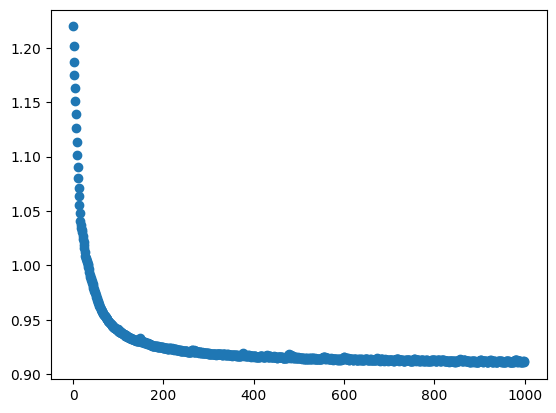

In [ ]:
# train simple logistic regression, and deeper models as baseline: Training

class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(Classifier, self).__init__()
        self.linear = torch.nn.Linear(input_size, input_size)
        # sequential
        layers = []
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(input_size, input_size))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(0.1))
            
        self.sequential = torch.nn.Sequential(*layers)
        self.linear_end = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.sequential(x)
        y_pred = F.sigmoid(self.linear_end(x))
        return y_pred

def make_model(lr, hidden_layers):
    model = Classifier(train_X.shape[1], hidden_layers)
    X = torch.from_numpy(train_X).float()
    y = torch.from_numpy(train_y).float().unsqueeze(1)

    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.functional.binary_cross_entropy
    rescale_weight_botsamples = len(train_y[train_y==0])/len(train_y[train_y==1])

    model.train()
    model.cuda()
    X = X.cuda()
    y = y.cuda()
    
    for epoch in tqdm(range(1000)):
        y_pred = model(X)
        weights = torch.ones_like(y).cuda()
        weights[y==1] = rescale_weight_botsamples
        loss = criterion(y_pred, y, weight = weights)
        
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # validation set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(val_X).float().cuda())
        f1 = f1_score(val_y, y_pred.detach().cpu()>0.5)
        precision = precision_score(val_y, y_pred.detach().cpu()>0.5)
        recall = recall_score(val_y, y_pred.detach().cpu()>0.5)
        print(f'val f1: {f1} precision: {precision} recall: {recall}')
    
    return f1, losses, model
        
# grid search
# if False:
lrs = [0.0001, 0.001, 0.01, 0.1,0.2]
hidden_layers = [0, 1,5,10]
lrs = [str(lr) for lr in lrs]
best_lr = None
best_hidden_layers = None
best_f1 = 0
best_model = None
best_losses = None
for hidden_layers in hidden_layers:
    for lr in lrs:
        print(f'lr: {lr}, hidden layers: {hidden_layers}')
        f1, losses, model = make_model(float(lr), hidden_layers)
        if f1 > best_f1:
            best_f1 = f1
            best_lr = lr
            best_model = model
            best_losses = losses
            best_hidden_layers = hidden_layers
# f1, losses, model = make_model(0.01)
print(f'best lr: {best_lr}, best hidden layers {best_hidden_layers}, val f1: {best_f1}')
plt.scatter(range(len(best_losses)), best_losses)
plt.show()


In [ ]:
# test performance on test set
model = best_model
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(test_X).float().cuda())
    f1 = f1_score(test_y, y_pred.detach().cpu()>0.5)
    precision = precision_score(test_y, y_pred.detach().cpu()>0.5)
    recall = recall_score(test_y, y_pred.detach().cpu()>0.5)
    accuracy = accuracy_score(test_y, y_pred.detach().cpu()>0.5)
    print(f'test f1: {f1} accuracy: {accuracy} precision: {precision} recall: {recall} ')
    

test f1: 0.43258979661493363 accuracy: 0.7173928260717393 precision: 0.3008209538702111 recall: 0.7697749196141479 


The most optimal model from the above configurations is found to be a simple logistic regression (only one layer, instead of multiple MLP layers) utilizing the information about the relationship count per relationship type per user. During training, the loss  corresponding to the minority class (bot) is weighted higher to reflect the class imbalance.


Interestingly this model outperforms
(F1: 43.3±0 %)  many of the methods the original paper implements on the TwiBot-22 dataset for demonstration purposes [2] (The original paper unfortunately does not specify the exact methodology for training, including split ratios).
Although the model has only access to the F- (feature-) and implicitly, through the relationship counts, G- (graph-) based information, no T- (text-) based information, it achieves acceptable F1 score in comparison, even outperforming the graph-based method Heterogenous Graph Transformer (HGT) [4] in the F1 metric. The graph based models have access to all FGT features:<br><br>
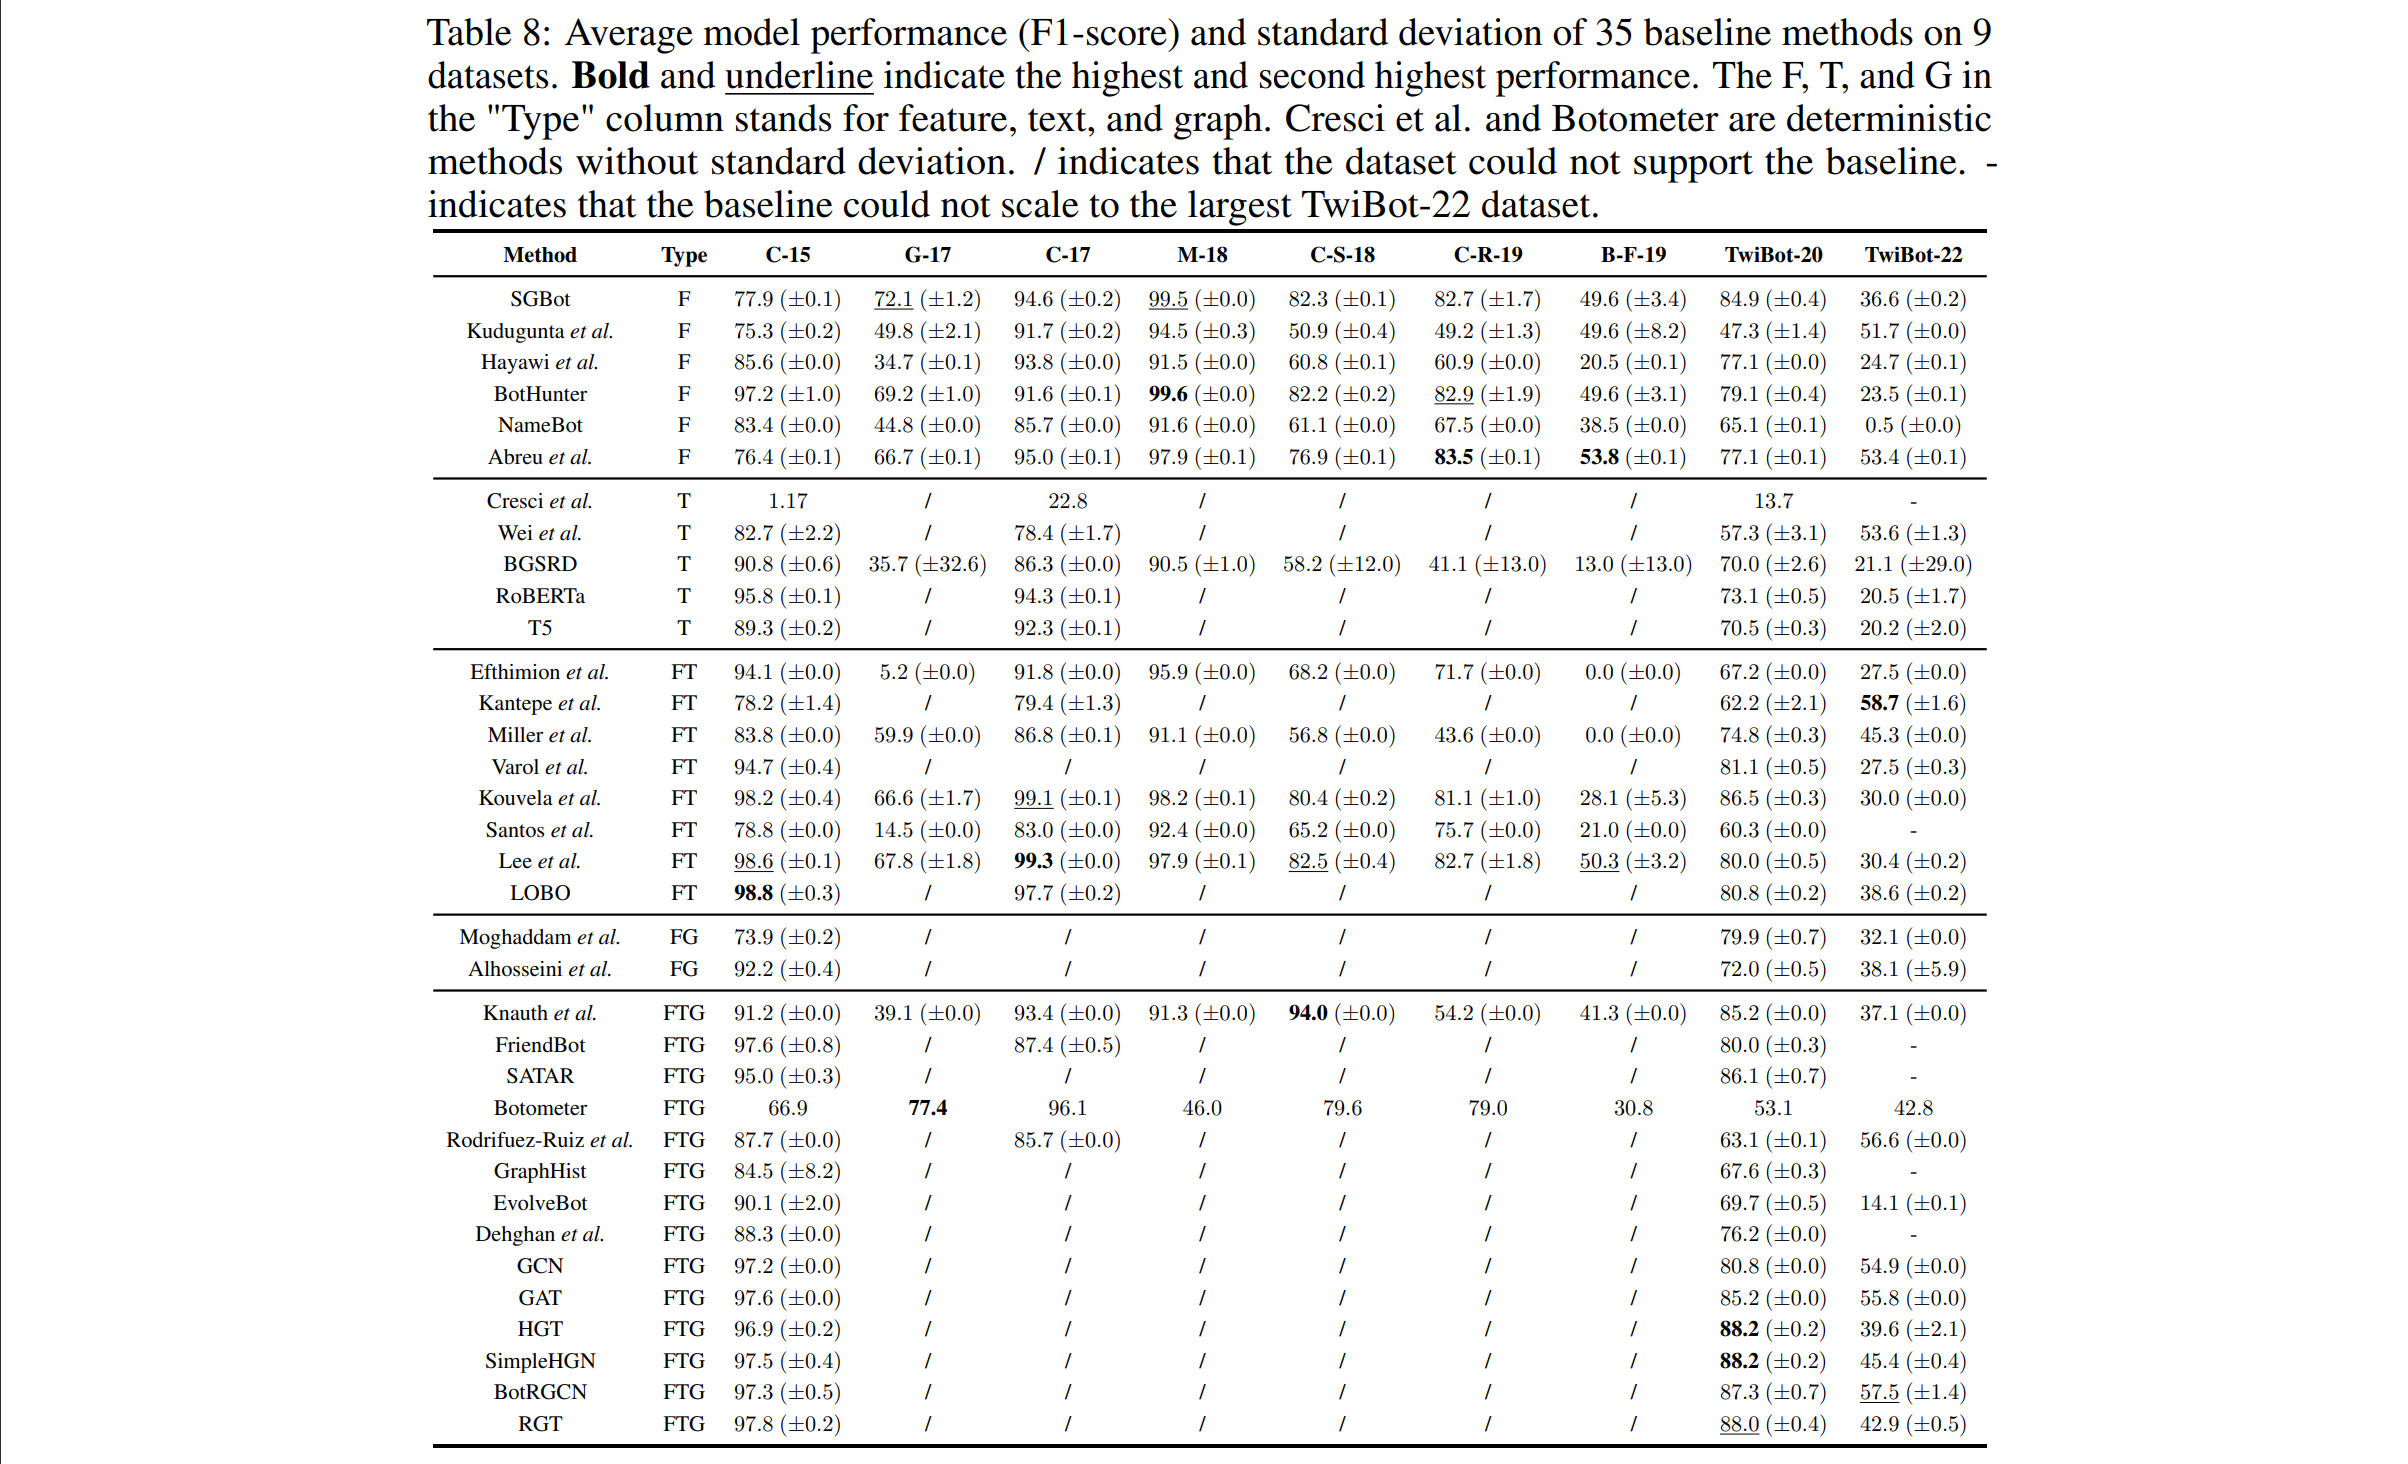

[4] https://arxiv.org/abs/2003.01332

The authors report accuracy scores as well, although the highest performing model outperforms a majority-class predictor only by 1% (87% accuracy) [2].


In the following, the impact of the Graph-based information on the models' performance is explored further utilizing a Graph Neural Network.

In [ ]:
all_relationship_counts = user_relationship_counts

In [ ]:
all_relationship_counts

relation             source_id  contain  discuss  followed  followers  \
0                    l10001332       99        0         5          0   
1                   l100016857       91        0         9          0   
2                   l100025292       97        0         1          0   
3         l1000424073703313409       98        0         0          0   
4         l1000427635304943616      100        0         0          0   
...                        ...      ...      ...       ...        ...   
26963190   u999991981249097728        0        0         0          0   
26963191   u999993859605172224        0        0         0          0   
26963192   u999996175070711808        0        0         0          0   
26963193            u999996786        0        0         0          0   
26963194   u999996798793109506        0        0         0          0   

relation  following  like  membership  mentioned  own  pinned  post  quoted  \
0                 0     0           7          0    0       0     0       0   
1                 0     0          57          0    0       0     0       0   
2                 0     0           1          0    0       0     0       0   
3                 0     0           8          0    0       0     0       0   
4                 0     0          14          0    0       0     0       0   
...             ...   ...         ...        ...  ...     ...   ...     ...   
26963190          0     0           0          0    0       0   200       0   
26963191          0     0           0          0    0       0    42       0   
26963192          0     0           0          0    1       1    47       0   
26963193          0     0           0          0    0       0    40       0   
26963194          0     0           0          0    0       0    40       0   

relation  replied_to  retweeted  
0                  0          0  
1                  0          0  
2                  0          0  
3                  0          0  
4                  0          0  
...              ...        ...  
26963190           0          0  
26963191           0          0  
26963192           0          0  
26963193           0          0  
26963194           0          0  

[26963195 rows x 15 columns]

In [23]:
# Create graph dataset

entity_types = ['user','tweet', 'list', 'hashtag']
relationship_types = {
 'followers': ('user', 'followers', 'user'),
 'following': ('user', 'following', 'user'),
 'own': ('user', 'own', 'list'),
 'pinned': ('user', 'pinned', 'tweet'),
 'post': ('user', 'post', 'tweet'),
 'contain': ('list', 'contain', 'tweet'),
 'discuss': ('tweet', 'discuss', 'hashtag'),
 'mentioned': ('tweet', 'mentioned', 'user'),
 'like': ('user', 'like', 'tweet'),
 'followed': ('list', 'followed', 'user'),
 'replied_to': ('tweet', 'replied_to', 'tweet'),
 'retweeted': ('tweet', 'retweeted', 'tweet'),
 'quoted': ('tweet', 'quoted', 'tweet'),
 'membership': ('list', 'membership', 'user')
}

unique_nodes = {}

temp1 = set(edges.source_id.unique().tolist())
temp2 = set(edges.target_id.unique().tolist())
temp_total = temp1.union(temp2)

number_of_nodes = {}
for entity_type in entity_types:
    nodes_of_type = [ i for i in temp_total if i.startswith(entity_type[0])]
    for i in range(len(nodes_of_type)):
        unique_nodes[nodes_of_type[i]] = i
    
    number_of_nodes[entity_type] = len(nodes_of_type)
        
edges['source_id'] = edges['source_id'].map(unique_nodes)
edges['target_id'] = edges['target_id'].map(unique_nodes)

del temp1, temp2, temp_total, nodes_of_type

In [ ]:
# save unique_nodes
torch.save(unique_nodes, 'data/unique_nodes.pt')

In [ ]:
# define graph dataset

data = HeteroData()
for entity_type in entity_types:
    data[entity_type].num_nodes = number_of_nodes[entity_type]

for edge_rel, edge_type in relationship_types.items():
    data[edge_type].edge_index = torch.tensor(edges[edges.relation==edge_rel][['source_id', 'target_id']].values.T, dtype=torch.long)
    edges.drop(edges[edges.relation==edge_rel].index, inplace=True)  # keep ram in check
    
del edges # keep ram in check
del label

In [ ]:
X = {}
for edge_rel, edge_type in relationship_types.items():
    src, rel, dst = edge_type
    
    output, counts = torch.unique(data[edge_type].edge_index[0,:], return_counts=True)
    src_counts = torch.zeros(data[src].num_nodes, 1).long()
    src_counts[output] = counts.unsqueeze(1)
    
    output, counts = torch.unique(data[edge_type].edge_index[1,:], return_counts=True)
    dst_counts = torch.zeros(data[dst].num_nodes, 1).long()
    dst_counts[output] = counts.unsqueeze(1)
    
    if src not in X:
        X[src] = src_counts
    else:
        X[src] = torch.cat([X[src], src_counts], dim=1)
    
    if dst not in X:
        X[dst] = dst_counts
    else:
        X[dst] = torch.cat([X[dst], dst_counts], dim=1)

In [ ]:
for entity_type, degrees in X.items():
    data[entity_type].x = degrees

In [ ]:
# save data
if not os.path.exists('data/TwiBot22_Graph_with_degreecounts3.pt'):
    torch.save(data, 'data/TwiBot22_Graph_with_degreecounts3.pt')

In [ ]:
# define model
from torch_geometric.nn import HGTConv, Linear
import torch 

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, node_types, data_metadata):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data_metadata,
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict
    
if __name__ == '__main__':
    model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=1, node_types=data.node_types, data_metadata=data.metadata())

## Model Training
Due to dataset size, the model is trained on Kaggle.com.
We try to reproduce the results of the Heterogeneous Graph Transformer, although the exact model hyperameters are unknown, we use a small two layer GNN (using only the graph-based , no text-based, information).

The following code is used for training:

In [ ]:
# Saving the data locally

import torch 
import pandas as pd
import os

data = torch.load('data/TwiBot22_Graph_with_degreecounts3.pt')
node_ids = torch.load('data/unique_nodes.pt')
    
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# remove user ids that are not in the graph
train_df = train_df[train_df['user_id'].isin(node_ids)]
test_df = test_df[test_df['user_id'].isin(node_ids)]

train_df['index'] = train_df['user_id'].apply(lambda x: node_ids[x])
test_df['index'] = test_df['user_id'].apply(lambda x: node_ids[x])
labels = train_df[['index', 'label']].values.tolist() + test_df[['index', 'label']].values.tolist()
sorted_labels = sorted(labels, key=lambda x: x[0])

assert list([x[0] for x in sorted_labels]) == list(range(0, len(sorted_labels)))

data['user'].y = torch.tensor([x[1] for x in sorted_labels])

subgraph_train_indices = {}
for node_type in data.node_types:
    subgraph_train_indices[node_type] = torch.arange(data[node_type]['num_nodes']).long()

subgraph_train_indices['user'] = torch.tensor(train_df['index'].values).long()

train_graph = data.subgraph(
    subgraph_train_indices
)

if not os.path.exists('data/TwiBot22_Graph_with_degreecounts_with_y.pt'):
    torch.save(data, 'data/TwiBot22_Graph_with_degreecounts_with_y.pt')
    torch.save(train_graph, 'data/TwiBot22_Graph_with_degreecounts_train_with_y.pt')
    
del data

In [ ]:
# loading the data on kaggle

train_graph = torch.load('/kaggle/input/twibot22-pyggraph/TwiBot22_Graph_with_degreecounts_train_with_y.pt')

In [ ]:
# the data object:
train_graph

HeteroData(
  user={
    num_nodes=899821,
    x=[899821, 11],
    y=[899821],
  },
  tweet={
    num_nodes=88217457,
    x=[88217457, 12],
  },
  list={
    num_nodes=21870,
    x=[21870, 4],
  },
  hashtag={
    num_nodes=5146289,
    x=[5146289, 1],
  },
  (user, followers, user)={ edge_index=[2, 903301] },
  (user, following, user)={ edge_index=[2, 2127231] },
  (user, own, list)={ edge_index=[2, 19645] },
  (user, pinned, tweet)={ edge_index=[2, 312223] },
  (user, post, tweet)={ edge_index=[2, 79393450] },
  (list, contain, tweet)={ edge_index=[2, 1998788] },
  (tweet, discuss, hashtag)={ edge_index=[2, 66000633] },
  (tweet, mentioned, user)={ edge_index=[2, 4258720] },
  (user, like, tweet)={ edge_index=[2, 538122] },
  (list, followed, user)={ edge_index=[2, 444505] },
  (tweet, replied_to, tweet)={ edge_index=[2, 1114980] },
  (tweet, retweeted, tweet)={ edge_index=[2, 1580643] },
  (tweet, quoted, tweet)={ edge_index=[2, 289476] },
  (list, membership, user)={ edge_index=[2,

In [ ]:
# Define GNN Model
from torch_geometric.nn import HGTConv, Linear

from torch.nn import functional as F

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, node_types, data_metadata):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data_metadata,
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['user'])
    
    
    
model = HGT(hidden_channels=256, out_channels=1, num_heads=8, num_layers=2, node_types=train_graph.node_types, data_metadata=train_graph.metadata())

In [ ]:
# Parameters for minibatch loader

from torch_geometric.loader import HGTLoader
batch_size = 32
num_node_types = len(train_graph.node_types)
one_hop_neighbors = (20 * batch_size)//num_node_types # per relationship type
two_hop_neighbors = (20 * 8 * batch_size)//num_node_types # per relationship type
#three_hop_neighbors = (20 * 8 * 3 * batch_size)//num_node_types # per relationship type
num_neighbors = [one_hop_neighbors, two_hop_neighbors]

for node_type in train_graph.node_types:
    train_graph[node_type].x = train_graph[node_type].x.float()

In [ ]:
# code for weight tracking (ensuring no over/underflow)

def record_grad_magnitudes(model, writer, step):
    grad_magnitudes = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_magnitudes.append(param.grad.data.norm(2).item())
            writer.add_scalar(f'GradientMagnitudes/{name}', param.grad.data.norm(2).item(), step)
    writer.add_scalar('GradientMagnitudes/Mean', sum(grad_magnitudes) / len(grad_magnitudes), step)

In [ ]:
# Code for weight loading (training on kaggle is longer than 12 hours, which is maximum allowed duration of a kernel runtime)
import gc 
def init(model, optimizer, state_dict_path, data):
    with torch.no_grad():
        model.eval()
        for node_type in data.node_types:
            print(node_type)

            loader = HGTLoader(
                    data.cuda(),
                    # Sample 512 nodes per type and per iteration for 4 iterations
                    num_samples=num_neighbors,
                    batch_size=64, #96 or 32 nodes
                    input_nodes=node_type,
                    num_workers=0,
                    pin_memory=True,
                    prefetch_factor=None,
                )
            minibatch = next(iter(loader))

            model(minibatch.x_dict, minibatch.edge_index_dict)
            model_and_optimizer = torch.load(state_dict_path)
            model.load_state_dict(model_and_optimizer['model_state_dict'])
            del loader
            gc.collect()
            
            
            optimizer.load_state_dict(model_and_optimizer['optimizer_state_dict'])

In [ ]:
# train model, line 23 can be used to init model with weights from a previous run 
# the loss function uses the class weighting explained later


from tqdm.auto import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from sklearn.metrics import precision_score, recall_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_folder = Path(f'runs/{timestamp}')
writer = SummaryWriter(run_folder)

model.train()

gc.collect()
model.cuda()
samples_seen = 0
epoch1 = 0
#init(model,optimizer, f'/kaggle/input/twibot22-hgt-models/model_epoch_{epoch1}_samplesseen_{samples_seen}.pt', train_graph)
train_graph=train_graph.cuda()
import random
l_ = len(train_graph['user'].y)
node_indices = list(range(l_))
random.seed(42)
random.shuffle(node_indices)
input_nodes_indices = node_indices[:l_//3]
#input_nodes_indices = input_nodes_indices[:32]
len(input_nodes_indices)
loader = HGTLoader(
        train_graph,
        num_samples=num_neighbors,
        batch_size=32,
        input_nodes=('user', input_nodes_indices), # train 33% of training nodes, the rest are used as neighbors
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        shuffle=True,
       drop_last=True
    )
with open('/kaggle/working/scores_train.csv', 'w') as csv_file:
    for epoch in range(epoch1, epoch1+5):
        epoch += epoch1
        for i,minibatch in enumerate(loader):
            seen_ = samples_seen+(i+1)*32 + epoch*len(loader)*32
            
            optimizer.zero_grad()
            out = model(minibatch.x_dict, minibatch.edge_index_dict)
            y = minibatch['user'].y[:32].unsqueeze(1).float() 
            logits = out[:32,:]
            weights = y*3.57 + (1-y)*0.58
            loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, y, weight=weights)
            loss.backward()
            
            if i % 100 == 0 or i == len(loader) - 1:
                record_grad_magnitudes(model, writer, seen_)
            
            optimizer.step()
            

            if i % 100 == 0 or i == len(loader) - 1:
                y_hat = logits>0
                y_hat, y = y_hat.cpu().detach(), y.cpu().detach()
                writer.add_scalar('Loss/train', loss.item(), seen_)
                f1= f1_score(y_hat, y)

                precision = precision_score(y_hat,y)
                recall = recall_score(y_hat,y)
           
                csv_file.write(f'{seen_},{f1},{precision},{recall}\n')

            #if i % 1000 == 0 or i == len(loader) - 1:
        torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, run_folder/f'model_epoch_{epoch}_samplesseen_{seen_}.pt')

In [ ]:
# sample evaluation code (holding the training and testing graph in gpu memory at the same time is not feasible, therefore training and testing is done separately)
del node_ids
gc.collect()
data = data.cuda()


model.cuda()
with open('/kaggle/working/scores.csv', 'w') as csv_file:
    csv_file.write('Samplesseen,F1\n')
    for path in [
       '/kaggle/input/twibot22-hgt-models/model_samplesseen2791744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen2951744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3111744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3335744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3463744.pt',
        '/kaggle/input/twibot22-hgt-models/model_samplesseen3591744.pt'
        
    ]:
        print('Loading state dict:',path)

        init(model,path)
        test_loader = HGTLoader(
            data,
            num_samples=num_neighbors,
            batch_size=32,
            input_nodes=('user', test_df['index'].values.tolist()),  # in testing the model can see the training user nodes, but only test nodes are used for testing
            num_workers=4,
            pin_memory=True,
            prefetch_factor=2,
            shuffle=True
        )

        with torch.no_grad():
            model.eval()
            y_hat = []
            y = []
            for i,minibatch in tqdm(enumerate(test_loader)):
                out = model(minibatch.x_dict, minibatch.edge_index_dict)
                yhat_b = (out>0).cpu().numpy()
                y_b = minibatch['user'].y.unsqueeze(1).float().cpu().numpy()
                print(i, f1_score(yhat_b, y_b), end='\r')
                y_hat.append(yhat_b)
                y.append(y_b)

            y_hat = np.concatenate(y_hat)
            y = np.concatenate(y)
            print('')
            f1= f1_score(y_hat, y)
            samplesseen = int(path.replace('/kaggle/input/twibot22-hgt-models/model_samplesseen','').replace('.pt',''))
            print('final',f1, 'samplesseen',samplesseen)
            print('')
            
            csv_file.write(f'{samplesseen},{f1}\n')

        del test_loader

### Experimental Results
Below, the training loss and validation F1 score are shown (Figure 1 and 2). The model is trained for 10 epochs.
One training epoch amounts to 6.8 hours, and total training time to 68 hours on a NVIDIA P100 GPU.

One training epoch corresponds to 810,000 node classifications. The model is trained with the Adam optimizer and a learning rate of 0.0002 and a minibatch size of 32. The evaluation is done on the remaining 90,000 nodes, which the model has not seen.

#### Equal class weighting
Some difficulties are experienced during training, as the model, in a first instance, only learns to predict the majority class. Checking gradients confirms that the cause is not numerical under- or overflow. Hence equal class weighting is applied.
<br><br>
Derivation of the equal class weighting:

$ \mathbb{E}[X] = p(a|X) \cdot w_a + p(b|X) \cdot w_b = c$  &nbsp; (1) <br><br>
$p(a|X) \cdot w_a = p(b|X) \cdot w_b$ &nbsp; (2) <br><br>
$p(a|X) = \frac{a}{a+b}; p(b|X) = \frac{b}{a+b}$ &nbsp;(3)<br>
<br>
$w_a = \frac{1}{2} \cdot \frac{c \cdot(a+b)}{a}; w_b = \frac{1}{2} \cdot \frac{c \cdot(a+b)}{b}$

Equation 1 and 2 are what we require as conditions. <br>(1) The weight of each sample x from our dataset X is altered but the expected sample "weight contribution" to the loss function should remain at $c=1$. <br>(2) both classes should contribute equally to the sample weight.

Setting $a=125948$, $b=774051$ and $c=1$ (constants from the training set where a is the bot class and b the human class) we get $w_a=3.57; w_b = 0.58$.


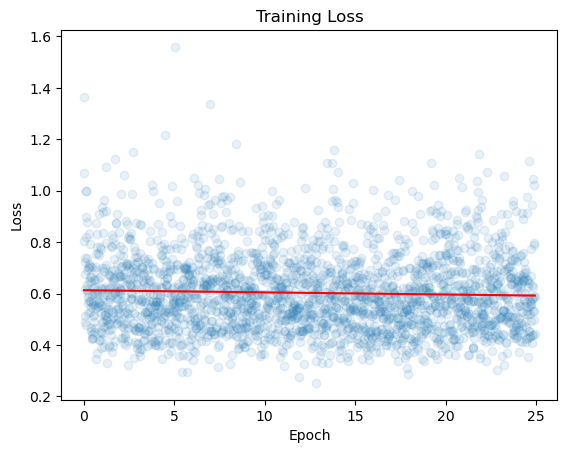

In [202]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])

    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    
    # this codes fixes wrong epoch numbers
    for tag in runlog_data.metric.unique(): 
        index = runlog_data['metric']==tag
        for i in range(len(runlog_data[index])-2):
            diff = runlog_data['step'].iloc[i+1] - runlog_data['step'].iloc[i]
            if diff > 3200:
                index[index.index<i] = False
                runlog_data.loc[index,'step'] -= diff +3200

    # remove artifacts >0.8 le7
    runlog_data = runlog_data[runlog_data['step']<0.8e7]
        
    return runlog_data
df=tflog2pandas("data_hgt")

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
X = np.array(df[df['metric']=='Loss/train']['step']/300000).reshape(-1,1)
y = np.array(df[df['metric']=='Loss/train']['value']).reshape(-1,1)
reg = LinearRegression().fit(X, y)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.scatter(df[df['metric']=='Loss/train']['step'] /300000,df[df['metric']=='Loss/train']['value'], alpha=0.1)
plt.plot(X, reg.predict(X), color='red')
plt.show()



The model learns really slowly - 5 epochs require 12 hours gpu time. Such that we stop after epoch 25.

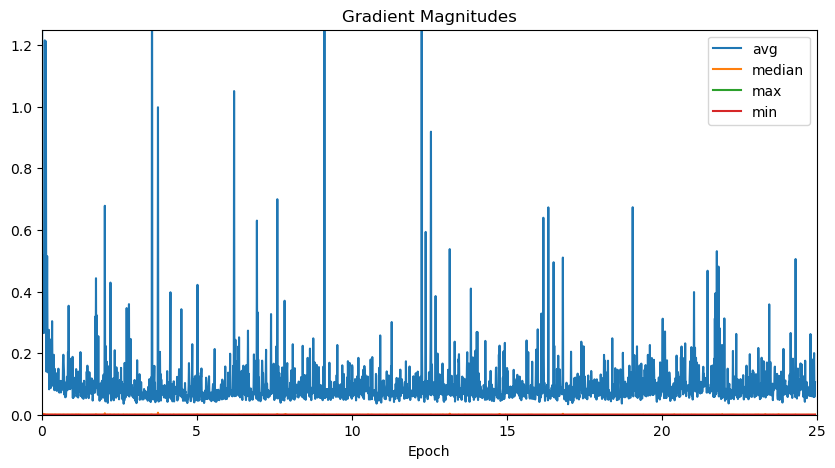

In [179]:
gradient_magnitudes = df[df['metric'].str.contains('GradientMagnitudes')]['metric'].unique()
gradient_magnitudes
df_avg = df[df['metric'].str.contains('GradientMagnitudes')].groupby('step')['value'].mean().reset_index()
df_avg.columns = ['step', 'avg']

df_median = df[df['metric'].str.contains('GradientMagnitudes')].groupby('step')['value'].median().reset_index()
df_median.columns = ['step', 'median']

df_max = df[df['metric'].str.contains('GradientMagnitudes')].groupby('step')['value'].max().reset_index()
df_max.columns = ['step', 'max']

df_min = df[df['metric'].str.contains('GradientMagnitudes')].groupby('step')['value'].min().reset_index()
df_min.columns = ['step', 'min']

# plot gradient magnitudes
plt.figure(figsize=(10,5))
plt.plot(df_avg['step']/300000, df_avg['avg'], label='avg')
plt.plot(df_median['step']/300000, df_median['median'], label='median')
plt.plot(df_max['step'], df_max['max'], label='max')
plt.plot(df_min['step']/300000, df_min['min'], label='min')
plt.ylim(0, 1.25)
plt.xlim(0, 25)
plt.legend()
plt.title('Gradient Magnitudes')
plt.xlabel('Epoch')
plt.show()


The average gradient magnitudes maybe exemplify that the model learns less after the first few epochs. Since the loss is not decreasing (and but flat/ increasing), we try to lower the learning rate from 1e-4 to 2e-5, however it shows no effect.

Text(0.5, 1.0, 'Training Performance')

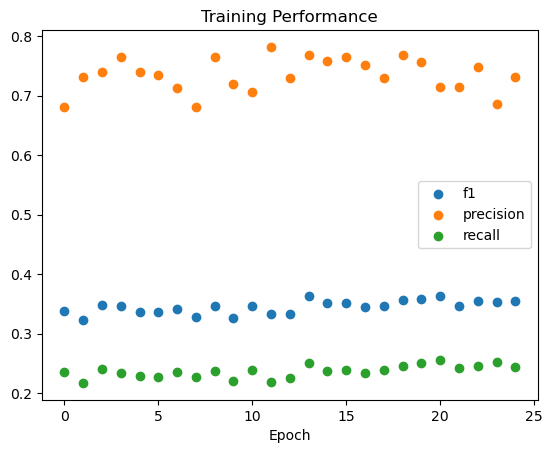

In [189]:
# seen, f1, precision, recall
# load csvs with "scores_train" in name from data_hgt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# fixing wrong epoch numbers
df1 = pd.read_csv('data_hgt/scores_train.csv', header=None)
df2 = pd.read_csv('data_hgt/scores_train2.csv', header=None)
df2.iloc[:,0] = df2.iloc[:,0]- (df2.iloc[:,0][0] - df1.iloc[-1,0])
df3 = pd.read_csv('data_hgt/scores_train3.csv', header=None)
df3.iloc[:,0] = df3.iloc[:,0]- (df3.iloc[:,0][0] - df2.iloc[-1,0])
df4 = pd.read_csv('data_hgt/scores_train4.csv', header=None)
df4.iloc[:,0] = df4.iloc[:,0]- (df4.iloc[:,0][0] - df3.iloc[-1,0])
df5 = pd.read_csv('data_hgt/scores_train5.csv', header=None)
df5.iloc[:,0] = df5.iloc[:,0]- (df5.iloc[:,0][0] - df4.iloc[-1,0])
df6 = pd.read_csv('data_hgt/scores_train6.csv', header=None)
df6.iloc[:,0] = df6.iloc[:,0]- (df6.iloc[:,0][0] - df5.iloc[-1,0])
df_total = pd.concat([df1, df2, df3, df4, df5, df6])
df_total.columns = ['seen', 'f1', 'precision', 'recall']

df_total['epoch'] = df_total['seen']//300000
df_total = df_total.groupby('epoch').mean().reset_index()

plt.scatter(df_total['epoch'], df_total['f1'], label='f1')
plt.scatter(df_total['epoch'], df_total['precision'], label='precision')
plt.scatter(df_total['epoch'], df_total['recall'], label='recall')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training Performance')


f1 at epoch 0: 0.3407963013853639
f1 at epoch 23: 0.3707750217160506


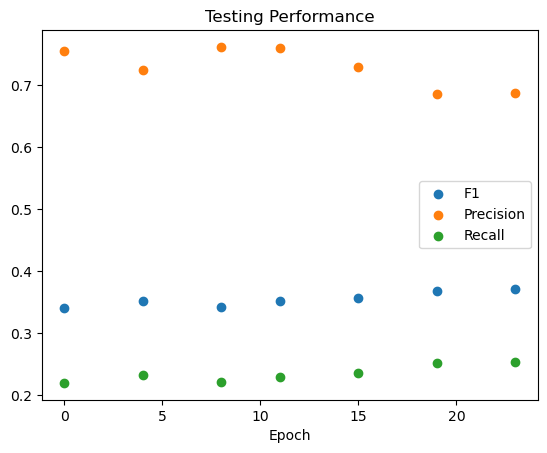

In [200]:
# testing performance
df = pd.read_csv('data_hgt/scores.csv', delimiter=';')
# plot f1, precision, recall with legend
plt.scatter(df['epoch'], df['F1'], label='F1')
plt.scatter(df['epoch'], df['precision'], label='Precision')
plt.scatter(df['epoch'], df['recall'], label='Recall')
plt.legend()
plt.xlabel('Epoch')
plt.title('Testing Performance')
print('f1 at epoch 0:', df[df['epoch']==0]['F1'].values[0])
print('f1 at epoch 23:', df[df['epoch']==23]['F1'].values[0])


The model achieves a testing f1 score of 37% which is lower than the simple logistic regression (43%). 
During training we only used 1/3 of the training user-nodes for classification, and the others only as neighbors.
Perhaps increasing this ratio could benefit performance (as the model will have more examples to classify using the last (linear) layer - resembling the logistic regression)

In [336]:
for a, b in zip(outs, y):
    print(a,b)

tensor(-1.0507) 0.0
tensor(-5.3660) 0.0
tensor(-1.7481) 0.0
tensor(-2.4193) 0.0
tensor(-2.1498) 0.0
tensor(-2.2751) 0.0
tensor(-8.5211) 0.0
tensor(-3.4186) 0.0
tensor(-3.9858) 0.0
tensor(-2.3957) 0.0
tensor(-2.0553) 0.0
tensor(-2.5318) 0.0
tensor(-2.6600) 0.0
tensor(-2.7147) 0.0
tensor(-1.1076) 0.0
tensor(-0.0954) 1.0
tensor(-3.4135) 1.0
tensor(-1.9423) 0.0
tensor(-0.1059) 0.0
tensor(-0.4482) 1.0
tensor(-3.3286) 1.0
tensor(-3.1976) 0.0
tensor(-1.1133) 0.0
tensor(-3.1752) 0.0
tensor(-1.9277) 0.0
tensor(0.4832) 0.0
tensor(-1.1076) 0.0
tensor(-4.3547) 0.0
tensor(-1.1076) 0.0
tensor(-1.1745) 1.0
tensor(-2.8830) 0.0
tensor(-3.4201) 0.0


Because of the large number of neighbors, each neighbortype is visualized separately: "user", "tweet", "list", "hashtag"

In [320]:
# merge 4 graphs
dataall = datafinal
data = dataall[1]
modified_heterographs = []
for graph1 in data:
    graph1['user']['y_hat'] = dataall[2][0]
    graph1['user']['logits'] = dataall[0][0]
    del graph1['n_id']
    modified_heterographs.append(graph1)


# define mappings
node_to_y_hat = {}
node_to_logits = {}
new_graph = HeteroData()

for graph in modified_heterographs:
    node_mappings = {}
    for node_type in graph.node_types:
        node_mappings[node_type] = {}

        for i,global_n_id in enumerate(graph[node_type].n_id):
            global_n_id = int(global_n_id)
            node_mappings[node_type][i] = int(global_n_id)
            if i<32 and node_type == 'user':
                node_to_y_hat[global_n_id] = graph['user']['y_hat'][i]
                node_to_logits[global_n_id] = float(graph['user']['logits'][i])
    
    # new_graph['user'].y = torch.tensor([node_to_y_hat[i] for i in range(len(node_to_y_hat))])
    # new_graph['user'].logits = torch.tensor([node_to_logits[i] for i in range(len(node_to_logits))])
                
    for edge_type in graph.edge_types:
        # remap edge type to global
        edge_index = graph[edge_type].edge_index
        edge_index[0] = torch.tensor([node_mappings[edge_type[0]][int(i)] for i in edge_index[0]])
        edge_index[1] = torch.tensor([node_mappings[edge_type[2]][int(i)] for i in edge_index[1]])
        if not edge_type in new_graph.edge_types:
            new_graph[edge_type].edge_index = edge_index
        else:
            new_graph[edge_type].edge_index = torch.cat([new_graph[edge_type].edge_index, edge_index], dim=1)

# remap to local node ids
global_to_local = {}    
for edge_type in new_graph.edge_types:
    src_type, _, dst_type = edge_type
    if src_type not in global_to_local:
        global_to_local[src_type] = {}
    if dst_type not in global_to_local:
        global_to_local[dst_type] = {}
    
    edge_index = new_graph[edge_type].edge_index
    for i,global_n_id in enumerate(edge_index[0]):
        global_n_id = int(global_n_id)
        if global_n_id not in global_to_local[src_type]:
            global_to_local[src_type][global_n_id] = len(global_to_local[src_type])
        edge_index[0][i] = global_to_local[src_type][global_n_id]
     
    for i,global_n_id in enumerate(edge_index[1]):
        global_n_id = int(global_n_id)
        if global_n_id not in global_to_local[dst_type]:
            global_to_local[dst_type][global_n_id] = len(global_to_local[dst_type])
        edge_index[1][i] = global_to_local[dst_type][global_n_id]

#add remaingin nodes which dont have edges in the current minibatch (target nodes are sampled at random, sometimes they could have no connection to other nodes in the minibatch)
for graph4 in  modified_heterographs:
    for node_type in graph4.node_types:
        for global_n_id in graph4[node_type].n_id:
            global_n_id = int(global_n_id)
            if global_n_id not in global_to_local[node_type]:
                global_to_local[node_type][global_n_id] = len(global_to_local[node_type])  
    
    new_graph[edge_type].edge_index = edge_index

# add ys and logits
local_ys = {}
for global_id in node_to_y_hat:
    local_ys[global_to_local['user'][global_id]] = node_to_y_hat[global_id]

local_logits = {}
for global_id in node_to_logits:
    local_logits[global_to_local['user'][global_id]] = node_to_logits[global_id]


for node_type in global_to_local:
    new_graph[node_type].num_nodes = len(global_to_local[node_type])    
 

In [247]:
new_graph  


HeteroData(
  user={ num_nodes=3807 },
  list={ num_nodes=2182 },
  tweet={ num_nodes=4931 },
  hashtag={ num_nodes=0 },
  (user, followers, user)={ edge_index=[2, 22027] },
  (user, following, user)={ edge_index=[2, 35891] },
  (user, own, list)={ edge_index=[2, 326] },
  (user, pinned, tweet)={ edge_index=[2, 0] },
  (user, post, tweet)={ edge_index=[2, 4481] },
  (list, contain, tweet)={ edge_index=[2, 1] },
  (tweet, discuss, hashtag)={ edge_index=[2, 0] },
  (tweet, mentioned, user)={ edge_index=[2, 3915] },
  (user, like, tweet)={ edge_index=[2, 48] },
  (list, followed, user)={ edge_index=[2, 1749] },
  (tweet, replied_to, tweet)={ edge_index=[2, 28] },
  (tweet, retweeted, tweet)={ edge_index=[2, 26] },
  (tweet, quoted, tweet)={ edge_index=[2, 1] },
  (list, membership, user)={ edge_index=[2, 8837] }
)

In [255]:
all_tweets = set()
for edge_type in new_graph.edge_types:
    src, rel, dst = edge_type
    if src == 'tweet':
        all_tweets.update(new_graph[edge_type].edge_index[0].tolist())
    if dst == 'tweet':
        all_tweets.update(new_graph[edge_type].edge_index[1].tolist())

len(all_tweets)
# min(list(all_tweets)), max(list(all_tweets))

4931

In [308]:
local_logits

{3807: -1.2291224002838135,
 2506: -3.2238073348999023,
 2507: -4.51676082611084,
 3808: -2.2089898586273193,
 2508: -2.5405585765838623,
 2509: -1.9983115196228027,
 3636: -0.07429654896259308,
 2510: -1.7417125701904297,
 3785: -0.9198983311653137,
 2511: -3.5373294353485107,
 3637: -3.7634332180023193,
 2512: -5.603772163391113,
 3797: -1.7052814960479736,
 3638: -3.1816375255584717,
 2513: -1.961334228515625,
 3639: -4.582330226898193,
 2514: -3.390676259994507,
 3640: 0.2975851893424988,
 3809: -1.2291224002838135,
 2515: -3.904905080795288,
 2516: -3.5047898292541504,
 3810: -1.2153196334838867,
 2517: -1.882164716720581,
 3811: -1.2305028438568115,
 2518: -0.8482765555381775,
 3641: -5.099934101104736,
 2519: -1.5614311695098877,
 3812: -1.2291224002838135,
 2520: -2.1305973529815674,
 2521: -3.60070538520813,
 2522: -3.3121254444122314,
 2523: -1.5584626197814941,
 2732: -1.2291224002838135,
 3822: -3.2238073348999023,
 2733: -4.51676082611084,
 2734: -2.2089898586273193,
 3786

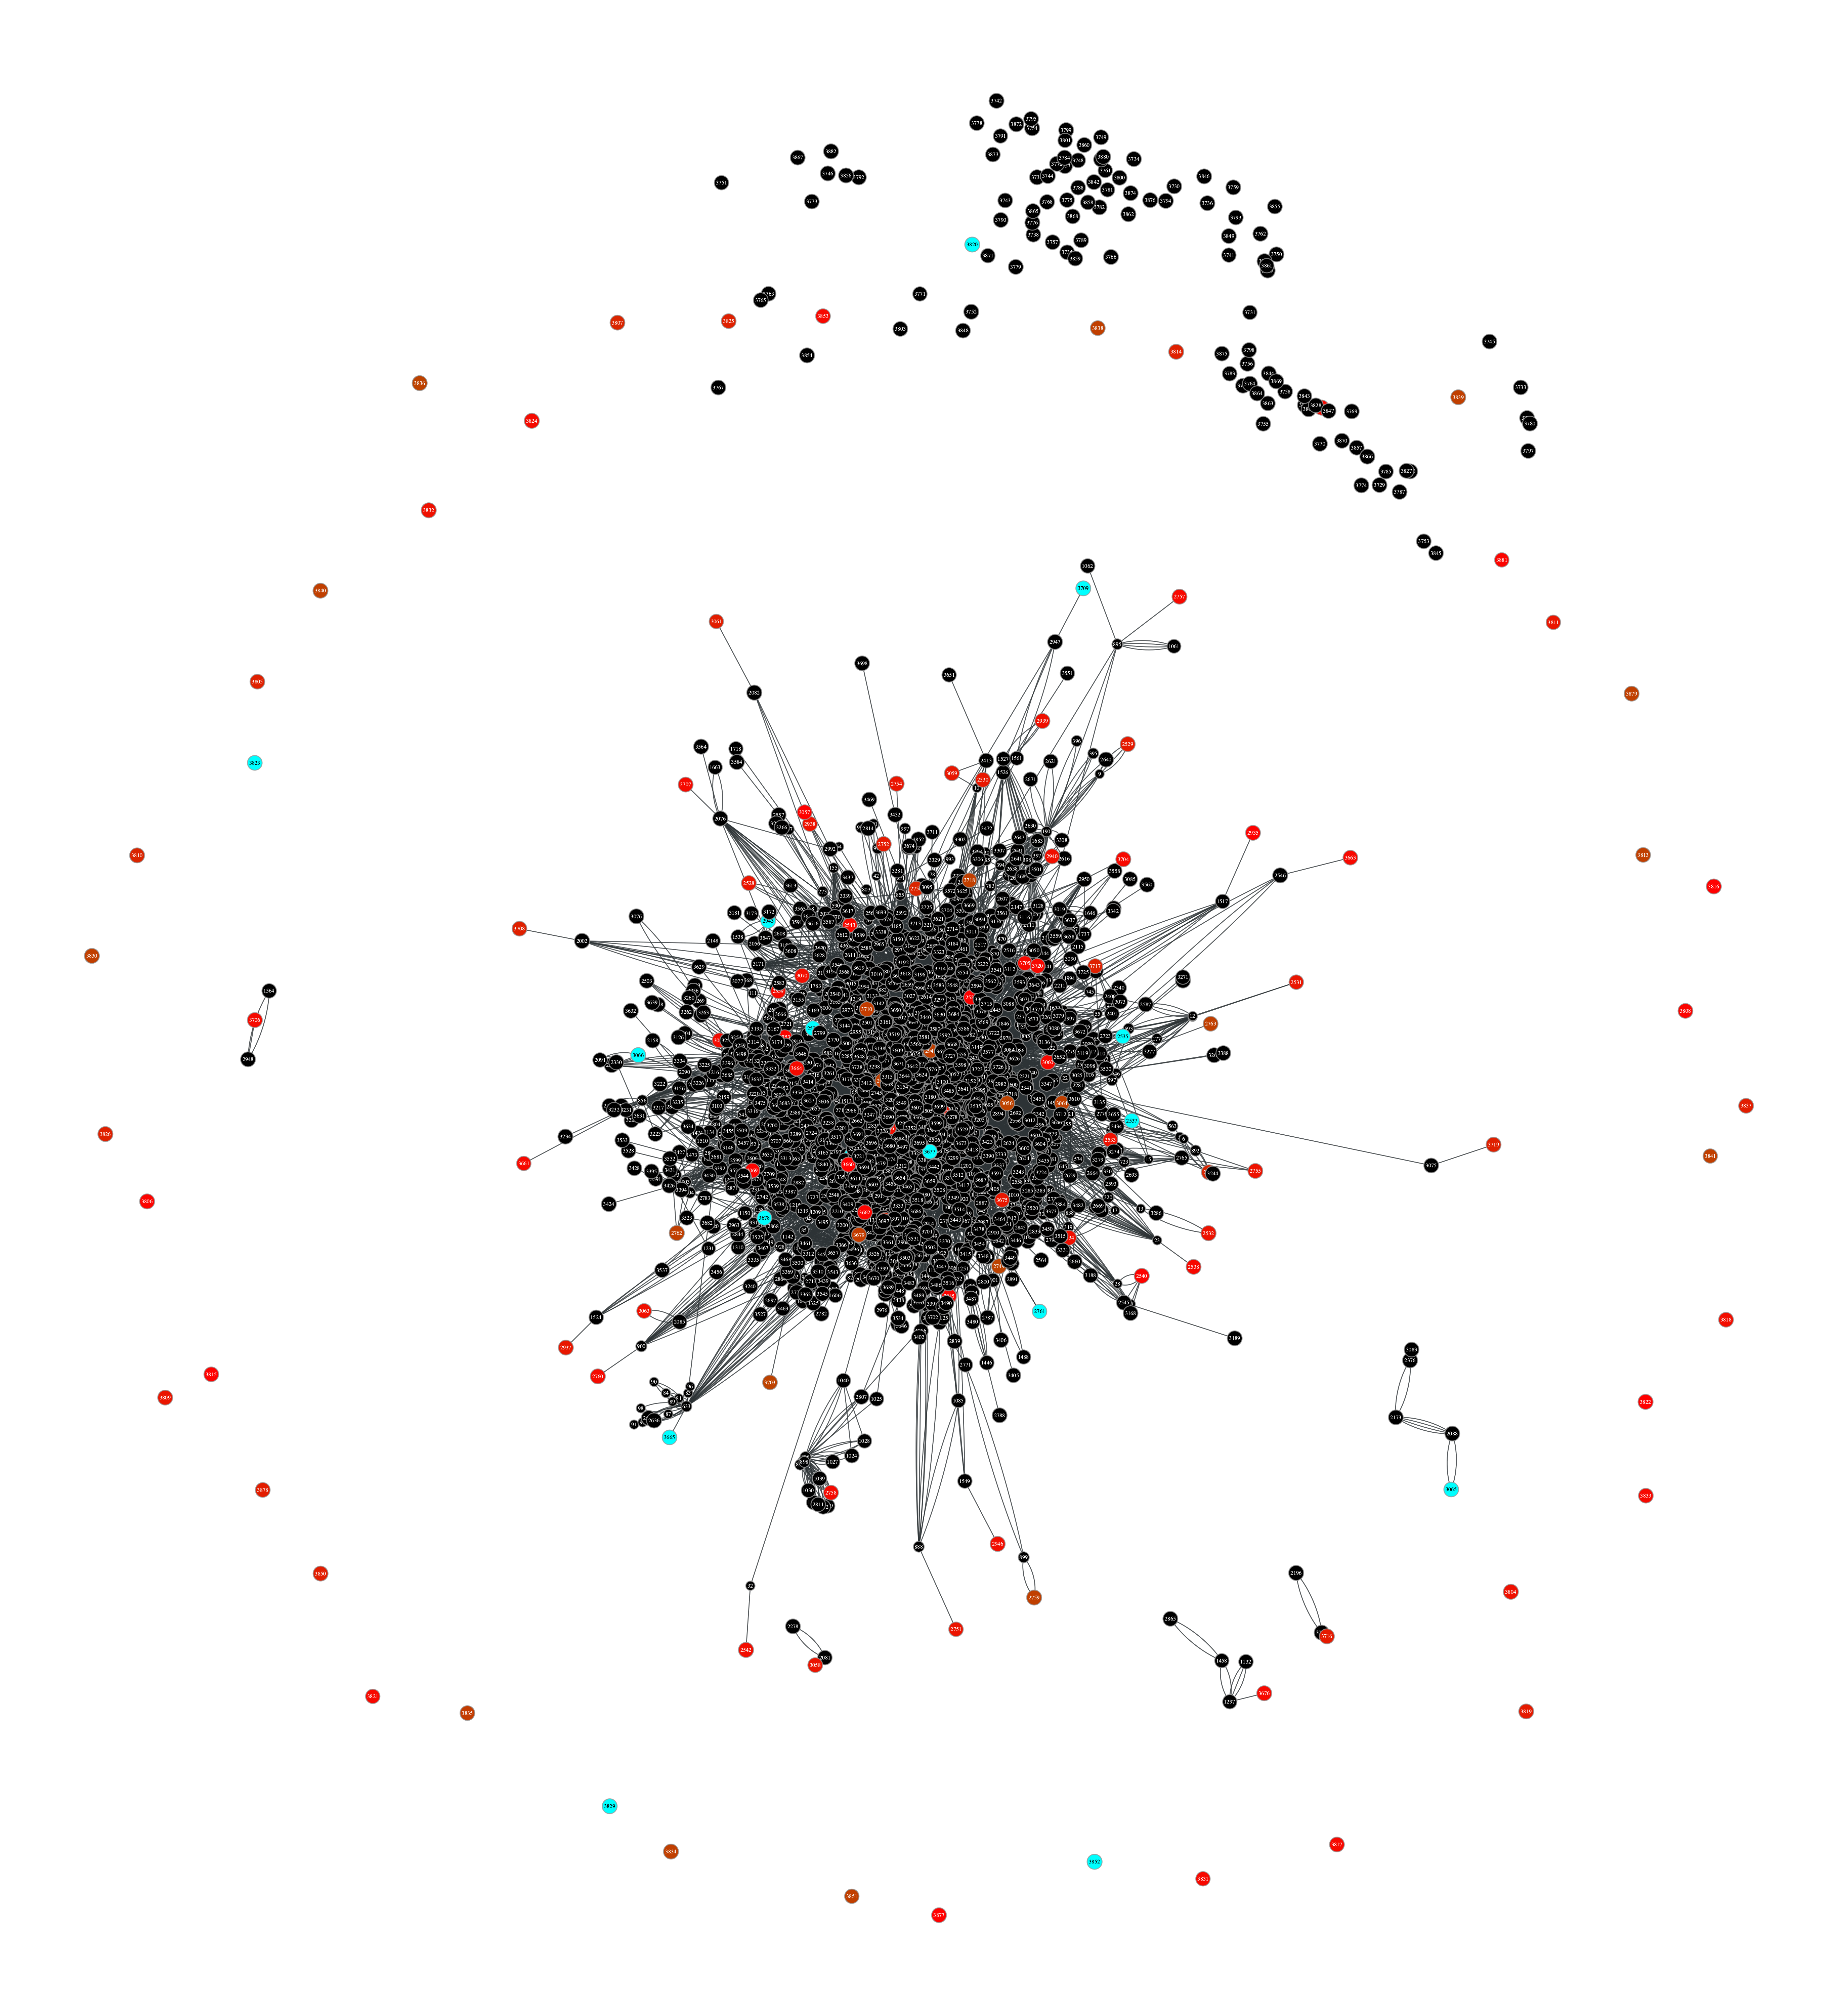

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17bba1d30, at 0x30ae28f10>

In [322]:
# Code after https://graph-tool.skewed.de/static/doc/quickstart.html

import pandas as pd
from graph_tool.all import Graph, graph_draw, sfdp_layout
import pickle
#outs1, data, y_hat1, y1 = 
from copy import deepcopy

current_graph = deepcopy(new_graph)
keep_node_types = ['user']
for edge_type in current_graph.edge_types:
    src, rel, dst = edge_type
    if src not in keep_node_types or dst not in keep_node_types:
        del current_graph[edge_type]

for node_type in current_graph.node_types:
    if node_type not in keep_node_types:
        del current_graph[node_type]

g = Graph(directed=False)
g.vertex_properties["node_type"] = g.new_vertex_property("string")
g.edge_properties["relation"] = g.new_edge_property("string")

g_node_index = {}
reverse_vertex_to_user = {}
# Add nodes
for node_type in current_graph.node_types:
    g_node_index[node_type] = {}    
    for i in range(current_graph[node_type].num_nodes):
        v = g.add_vertex()
        g_node_index[node_type][i] = v
        if node_type == 'user':
            reverse_vertex_to_user[v] = i
        g.vertex_properties["node_type"][v] = node_type


for edge_type in current_graph.edge_types:
    src_type, _, dst_type = edge_type
    edge_index = current_graph[edge_type].edge_index
    for i in range(edge_index.shape[1]):
        src = g_node_index[src_type][int(edge_index[0][i])]
        dst = g_node_index[dst_type][int(edge_index[1][i])]
        e = g.add_edge(src, dst)
        g.edge_properties["relation"][e] = '_'.join(edge_type)




# Define color maps for node types and edge relations
node_colors = ["red", "green", "blue", "orange", "purple", "brown"]
# edge_colors = ["black", "gray", "pink", "yellow", "cyan", "magenta"]

import matplotlib.colors as mcolors
# Convert color names to RGBA
node_colors_rgba = [mcolors.to_rgba(color) for color in node_colors]
# edge_colors_rgba = [mcolors.to_rgba(color) for color in edge_colors]

# Assign colors to node types
unique_node_types = current_graph.node_types

node_color_map = {
    # 'user': mcolors.to_rgba('black'),
 'list': mcolors.to_rgba('purple'),
 'tweet': mcolors.to_rgba('blue'),
 'hashtag': mcolors.to_rgba('brown'),
}
vertex_fill_color = g.new_vertex_property("vector<double>")
vweight = g.new_vertex_property("double")



for v in g.vertices():
    node_type = g.vertex_properties["node_type"][v]
    if node_type == 'user':
        # vertex_fill_color[v] = mcolors.to_rgba('black')
        local_user = reverse_vertex_to_user[v]
        if local_user in local_logits and local_user in local_ys:
            # define the color as scaling in a sigmoid function
            p = 1/(1+np.exp(-local_logits[local_user]))
            
       
            if p<0.5 and local_ys[local_user] == 1:
                print('white')
                vertex_fill_color[v] = mcolors.to_rgba('white')
            elif p>=0.5 and local_ys[local_user] == 0:
                print('white')
                vertex_fill_color[v] = mcolors.to_rgba('white')
            elif p<0.7 and p>=0.3:
                vertex_fill_color[v] = mcolors.to_rgba('cyan')
            elif p<0.5 and local_ys[local_user] == 0:
                vertex_fill_color[v] = (1-p, p, 0, 1)
            elif p>=0.5 and local_ys[local_user] == 1:
                vertex_fill_color[v] = (1-p, p, 0, 1)
        


            vweight[v] = 100
        else:
            vertex_fill_color[v] = mcolors.to_rgba('black')
            vweight[v] = 1
    else:
        vertex_fill_color[v] = node_color_map[node_type]
        vweight[v] = 1



pos = sfdp_layout(g,
    vweight=vweight,
    C=0.5,          # Increase repulsive force strength
    K=1.0,          # Set optimal edge length
    p=1.5,          # Adjust repulsive force exponent
    r=0.005,          # Reduce attractive force strength
    theta=0.001,      # Increase quadtree opening parameter
    gamma=1,     # Lower group attractive force
    adaptive_cooling=True,
    max_iter=8
                  )
graph_draw(
    g, 
    pos=pos,
    vertex_text=g.vertex_index,
    vertex_fill_color=vertex_fill_color,
    # edge_color=edge_color_prop,
    output_size=(3000, 3000),
    # output="graph-visualization.svg",
    # inline=True
)


In [267]:
mcolors.to_rgba('lightred')

ValueError: Invalid RGBA argument: 'lightred'

In [262]:
unique_node_types

['user', 'list', 'tweet', 'hashtag']

In [261]:
node_colors_rgba

[(1.0, 0.0, 0.0, 1.0),
 (0.0, 0.5019607843137255, 0.0, 1.0),
 (0.0, 0.0, 1.0, 1.0),
 (1.0, 0.6470588235294118, 0.0, 1.0),
 (0.5019607843137255, 0.0, 0.5019607843137255, 1.0),
 (0.6470588235294118, 0.16470588235294117, 0.16470588235294117, 1.0)]

In [259]:
node_color_map

{'user': (1.0, 0.0, 0.0, 1.0),
 'list': (0.0, 0.5019607843137255, 0.0, 1.0),
 'tweet': (0.0, 0.0, 1.0, 1.0),
 'hashtag': (1.0, 0.6470588235294118, 0.0, 1.0)}

In [221]:
all_edge_count = 0
for edge_type in new_graph.edge_types:
    all_edge_count += new_graph[edge_type].edge_index.shape[1]    

In [223]:
all_edge_count

77330

In [214]:
g.vertex_properties["node_type"][v]

'user'

### Discussion
The model achieves an F1 score of more than 69%, outperforming all models from the original Twibot-22 paper [2] (The best model achieves an F1 score of 58%).
Interestingly, their implementation of the Heterogeneous Graph Transformer architecture only achieves an F1 of 39%. Since a naive logistic regression achieves an F1 score of 43% (as evaluated earlier), the performance of 69% is plausible.

Opposed to the original implementation in Twibot-22, we only utilize the graph information (relationship information) as initial node features. The original implementation also leverages text information from user descriptions and tweets as well as numerical and categorical user property information.

Unfortunately, the original paper lacks a description of data splitting and the training approach or schedule. The performance deviation could be caused by insufficient training in the original paper's case.
Inspecting Figure 2, the F1 score only increases after the model has trained by making at least 810,000 classifications (one epoch). Perhaps the authors limited the training, since the main subject of the Twibot-22 paper is the dataset itself, and the authors had to compare many different models. They provide the testing performance in comparison to earlier datasets in the field, such that their results are still interpretable.
